## Birthrate Data

As a more interesting example, let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC).
This data can be found at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv
(this dataset has been analyzed rather extensively by Andrew Gelman and his group; see, for example, [this blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# !curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  258k  100  258k    0     0   165k      0  0:00:01  0:00:01 --:--:--  168k


In [7]:
births = pd.read_csv('births.csv')

In [8]:
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


In [9]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


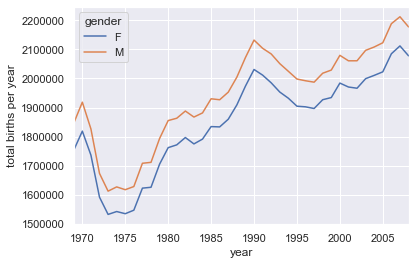

In [12]:
%matplotlib inline
sns.set()  # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

### Further data exploration

Though this doesn't necessarily relate to the pivot table, there are a few more interesting features we can pull out of this dataset using the Pandas tools covered up to this point.
We must start by cleaning the data a bit, removing outliers caused by mistyped dates (e.g., June 31st) or missing values (e.g., June 99th).
One easy way to remove these all at once is to cut outliers; we'll do this via a robust sigma-clipping operation:

In [13]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

This final line is a robust estimate of the sample mean, where the 0.74 comes from the interquartile range of a Gaussian distribution (You can learn more about sigma-clipping operations in a book I coauthored with Željko Ivezić, Andrew J. Connolly, and Alexander Gray: "Statistics, Data Mining, and Machine Learning in Astronomy" (Princeton University Press, 2014)).

With this we can use the query() method to filter-out rows with births outside these values:

In [16]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

Next we set the ``day`` column to integers; previously it had been a string because some columns in the dataset contained the value ``'null'``:

In [17]:
# set 'day' column to integer; it originally was a string due to nulls
births['day'] = births['day'].astype(int)

Finally, we can combine the day, month, and year to create a Date index. This allows us to quickly compute the weekday corresponding to each row:

In [19]:
# create a datetime index from the year, month, day
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek

Using this we can plot births by weekday for several decades:

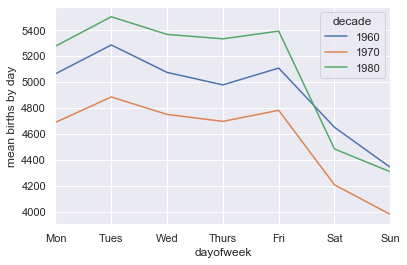

In [21]:
import matplotlib.pyplot as plt

births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

Apparently births are slightly less common on weekends than on weekdays! Note that the 1990s and 2000s are missing because the CDC data contains only the month of birth starting in 1989.

Another intersting view is to plot the mean number of births by the day of the *year*.
Let's first group the data by month and day separately:

In [35]:
births_by_date = births.pivot_table('births', 
                                    columns = births.index.day, index = births.index.month)
births_by_date

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
1,4009.225,4247.400,4500.900,4571.350,4603.625,4668.150,4706.925,4629.650,4537.775,4591.700,...,4742.800,4666.750,4653.200,4698.000,4715.900,4747.025,4771.800,4702.300,4644.225,4598.275
2,4661.450,4743.025,4761.825,4760.825,4728.300,4678.100,4649.650,4668.525,4713.575,4800.850,...,4751.525,4757.450,4829.000,4857.025,4790.575,4693.750,4695.300,4623.400,NaN,NaN
3,4742.175,4750.550,4871.775,4821.550,4781.600,4721.875,4722.450,4718.225,4692.075,4785.375,...,4667.200,4697.200,4725.050,4773.650,4722.825,4680.850,4694.650,4665.025,4663.425,4723.250
4,4623.825,4743.825,4652.925,4679.525,4586.825,4642.850,4689.850,4712.025,4649.875,4610.675,...,4686.700,4643.725,4581.150,4602.250,4588.500,4571.950,4656.550,4613.250,4615.100,NaN
5,4651.275,4616.700,4570.225,4577.000,4687.300,4678.950,4658.950,4623.750,4608.850,4623.175,...,4713.500,4721.100,4689.125,4661.925,4657.750,4738.150,4671.650,4704.050,4601.175,4597.050
6,4751.475,4804.650,4783.275,4744.475,4706.875,4771.850,4681.050,4681.950,4784.275,4831.375,...,4795.625,4850.550,4897.525,4890.925,4853.975,4852.325,4862.975,4881.650,4981.600,NaN
7,5021.975,5021.450,4869.425,4335.325,4698.825,4984.500,5153.425,5159.800,5075.400,5041.300,...,5135.675,5092.275,5036.050,5029.325,4998.700,5070.250,5133.525,5151.900,5101.225,5045.275
8,5068.000,5008.525,5065.250,5087.950,5108.000,5110.925,5082.675,5153.575,5027.775,5083.375,...,5058.850,5007.050,5035.200,5107.675,5167.500,5124.700,5099.775,5062.000,5027.850,5048.650
9,4908.325,4982.000,5003.925,5013.400,4954.600,4955.000,4995.450,5165.475,5263.400,5214.500,...,5316.825,5320.425,5284.050,5240.000,5250.650,5190.150,5168.450,5218.825,5224.775,NaN
10,5167.325,5103.625,5067.375,5005.175,5025.075,5048.100,5024.100,4989.875,4945.425,4975.975,...,4810.250,4755.500,4758.775,4744.350,4788.050,4821.350,4826.100,4775.575,4745.050,4662.800


To visualize this result, we can add a fake year information. let's turn these months and days into a date by associating them with a dummy year variable (making sure to choose a leap year so February 29th is correctly handled!)

In [36]:
births_by_date2 = births_by_date.stack()

In [37]:
births_by_date2.index = [pd.datetime(2000, month, day)
                        for (month, day) in births_by_date2.index]
births_by_date2.head()

2000-01-01    4009.225
2000-01-02    4247.400
2000-01-03    4500.900
2000-01-04    4571.350
2000-01-05    4603.625
dtype: float64

Focusing on the month and day only, we now have a time series reflecting the average number of births by date of the year. From this, we can use the plot method to plot the data. It reveals some interesting trends:

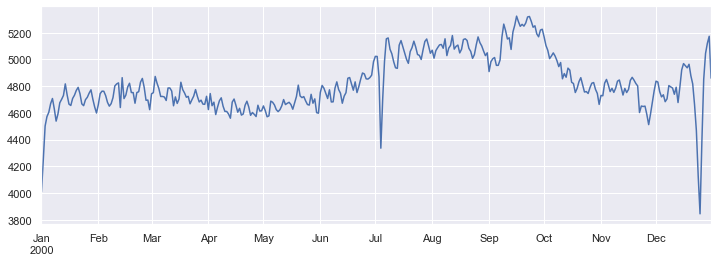

In [39]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date2.plot(ax=ax);

In particular, the striking feature of this graph is the dip in birthrate on US holidays (e.g., Independence Day, Labor Day, Thanksgiving, Christmas, New Year's Day) although this likely reflects trends in scheduled/induced births rather than some deep psychosomatic effect on natural births. For more discussion on this trend, see the analysis and links in Andrew Gelman's blog post on the subject. We'll return to this figure in Example:-Effect-of-Holidays-on-US-Births, where we will use Matplotlib's tools to annotate this plot.

Looking at this short example, you can see that many of the Python and Pandas tools we've seen to this point can be combined and used to gain insight from a variety of datasets. We will see some more sophisticated applications of these data manipulations in future sections!